# Libraries 

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import preprocessing


warnings.filterwarnings('ignore')

# Load Data

In [355]:
sales_train_df = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
item_categories_df = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
items_df = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
shops_df = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
test_set_df = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sample_submission_df = pd.read_csv('competitive-data-science-predict-future-sales/sample_submission.csv')

print('sales_train_df: ',sales_train_df.shape)
print('item_categories_df ',item_categories_df.shape)
print('items_df ',items_df.shape)
print('shops_df ', shops_df.shape)

sales_train_df:  (2935849, 6)
item_categories_df  (84, 2)
items_df  (22170, 3)
shops_df  (60, 2)


In [299]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [300]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [301]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Basic EDA before merging

## sales_train_df

In [358]:
sales_train_df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


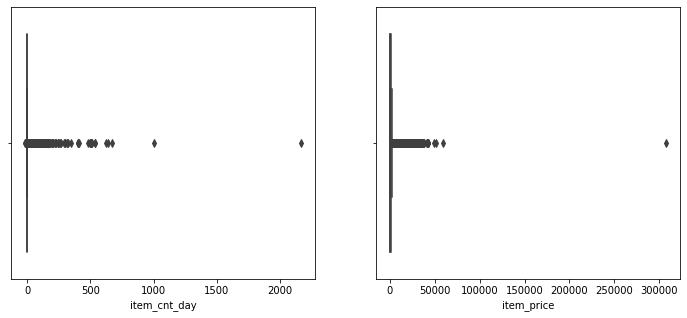

In [360]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,5))
sns.boxplot(sales_train_df['item_cnt_day'], ax = axes[0])
sns.boxplot(sales_train_df['item_price'], ax = axes[1])

In [361]:
sales_train_df = sales_train_df.loc[sales_train_df['item_cnt_day'] < 800]
sales_train_df = sales_train_df.loc[sales_train_df['item_price'] < 100000]

##### There are duplicated names of the shops, so we have to deal with that

In [302]:
def adjust_duplicated_shops(df):
    'Function that combines duplicated shop names'
    # from https://www.kaggle.com/taranenkodaria/predict-future-sales-the-russian-forecast
    # Test Set unique shop_id --> we should only use these ids
    # array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
    #   26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
    #   50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)
    
    df.loc[df['shop_id'] == 0, 'shop_id'] = 57
    df.loc[df['shop_id'] == 1, 'shop_id'] = 58
    df.loc[df['shop_id'] == 11, 'shop_id'] = 10
    df.loc[df['shop_id'] == 40, 'shop_id'] = 39
    df.loc[df['shop_id'] == 23, 'shop_id'] = 24
    
    return df

In [303]:
sales_train_df_no_dupl_shops = adjust_duplicated_shops(sales_train_df)

In [304]:
print('Before adjustment')
print(sales_train_df['shop_id'].value_counts().sort_index())

print('After adjustment')
print(sales_train_df_no_dupl_shops['shop_id'].value_counts().sort_index())

Before adjustment
2      25991
3      25532
4      38242
5      38179
6      82663
7      58076
8       3412
9       3751
10     21896
12     34694
13     17824
14     36979
15     59511
16     52734
17     22950
18     53227
19     63911
20      1792
21     58133
22     45434
24     59995
25    186104
26     53910
27    105366
28    142234
29     49225
30     50860
31    235636
32      7947
33      5027
34      5752
35     58445
36       306
37     39638
38     46013
39     17697
41     41967
42    109253
43     39282
44     39530
45     35891
46     66321
47     56695
48     21612
49     15849
50     65173
51     44433
52     43502
53     52921
54    143480
55     34769
56     69573
57    127285
58     77119
59     42108
Name: shop_id, dtype: int64
After adjustment
2      25991
3      25532
4      38242
5      38179
6      82663
7      58076
8       3412
9       3751
10     21896
12     34694
13     17824
14     36979
15     59511
16     52734
17     22950
18     53227
19     63911
2

## shops_df

##### Exctract features from shop_name

In [305]:
# drop already deleted "shop_id"
shops_df = shops_df.loc[~shops_df['shop_id'].isin([0, 1, 11, 40, 23])]

In [306]:
shops_df

,shop_name,shop_id
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9
10,Жуковский ул. Чкалова 39м?,10
12,Интернет-магазин ЧС,12


In [307]:
def extract_shop_type(df):
    'Extracts type of the shop and creates the shop_type_1 and shop_type_2 columns'
    
    df['shop_type_1'] = 'NONE'
    df['shop_type_2'] = 'NONE'
    
    df.loc[df['shop_name'].str.contains('ТЦ'),'shop_type_1'] = 'type_1'
    df.loc[df['shop_name'].str.contains('ТК'),'shop_type_1'] = 'type_2'
    df.loc[df['shop_name'].str.contains('ТРЦ'),'shop_type_1'] = 'type_3'
    df.loc[df['shop_name'].str.contains('ТРК'),'shop_type_1'] = 'type_4' 
    
    df.loc[(df['shop_name'].str.contains('ТЦ')) |
           (df['shop_name'].str.contains('ТК')),'shop_type_2'] = 'type_1'
    df.loc[(df['shop_name'].str.contains('ТРЦ')) |
           (df['shop_name'].str.contains('ТРК')),'shop_type_2'] = 'type_2'
    
    return df

def extract_shop_city(df):
    'Extracts shop city name and city type and creates two new columns'
    
    # City type: 1 if city is Moscow or Sankt Petersburg (they are quite different from the rest of Russia)
    df['shop_city_type'] = 0
    
    df['shop_city'] = df['shop_name'].str.split(' ').str[0]
    df.loc[df['shop_city'].isin(['Москва','СПб']),'shop_city_type'] = 1
    
    le = preprocessing.LabelEncoder()
    df['shop_city'] = le.fit_transform(df['shop_city'])
    
    return df

In [308]:
shops_df = extract_shop_type(shops_df)
shops_df = extract_shop_city(shops_df)

In [309]:
shops_df

,shop_name,shop_id,shop_type_1,shop_type_2,shop_city_type,shop_city
2,"Адыгея ТЦ ""Мега""",2,type_1,type_1,0,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,type_4,type_2,0,1
4,"Волжский ТЦ ""Волга Молл""",4,type_1,type_1,0,2
5,"Вологда ТРЦ ""Мармелад""",5,type_3,type_2,0,3
6,"Воронеж (Плехановская, 13)",6,NONE,NONE,0,4
7,"Воронеж ТРЦ ""Максимир""",7,type_3,type_2,0,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,type_3,type_2,0,4
9,Выездная Торговля,9,NONE,NONE,0,5
10,Жуковский ул. Чкалова 39м?,10,NONE,NONE,0,6
12,Интернет-магазин ЧС,12,NONE,NONE,0,7


## item_categories_df

In [310]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [311]:
def correct_item_category_name(df):
    'adjust the format of the "item_category_name" column'
    df.loc[df['item_category_name'] == 'Билеты (Цифра)','item_category_name'] = 'Билеты - Цифра'
    df.loc[df['item_category_name'] == 'Доставка товара','item_category_name'] = 'Доставка товара - service'
    df.loc[df['item_category_name'] == 'Карты оплаты (Кино, Музыка, Игры)',
           'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
    df.loc[df['item_category_name'] == 'Служебные','item_category_name'] = 'Служебные - none'
    df.loc[df['item_category_name'] == 'Чистые носители (шпиль)','item_category_name'] = 'Чистые носители - шпиль'
    df.loc[df['item_category_name'] == 'Чистые носители (штучные)','item_category_name'] = 'Чистые носители - штучные'
    df.loc[df['item_category_name'] == 'Элементы питания','item_category_name'] = 'Элементы питания - none'
    
    return df

item_categories_df_corrected = correct_item_category_name(item_categories_df)

# Check the results
for item in item_categories_df_corrected['item_category_name']:
    print(item)

PC - Гарнитуры/Наушники
Аксессуары - PS2
Аксессуары - PS3
Аксессуары - PS4
Аксессуары - PSP
Аксессуары - PSVita
Аксессуары - XBOX 360
Аксессуары - XBOX ONE
Билеты - Цифра
Доставка товара - service
Игровые консоли - PS2
Игровые консоли - PS3
Игровые консоли - PS4
Игровые консоли - PSP
Игровые консоли - PSVita
Игровые консоли - XBOX 360
Игровые консоли - XBOX ONE
Игровые консоли - Прочие
Игры - PS2
Игры - PS3
Игры - PS4
Игры - PSP
Игры - PSVita
Игры - XBOX 360
Игры - XBOX ONE
Игры - Аксессуары для игр
Игры Android - Цифра
Игры MAC - Цифра
Игры PC - Дополнительные издания
Игры PC - Коллекционные издания
Игры PC - Стандартные издания
Игры PC - Цифра
Карты оплаты - Кино, Музыка, Игры
Карты оплаты - Live!
Карты оплаты - Live! (Цифра)
Карты оплаты - PSN
Карты оплаты - Windows (Цифра)
Кино - Blu-Ray
Кино - Blu-Ray 3D
Кино - Blu-Ray 4K
Кино - DVD
Кино - Коллекционное
Книги - Артбуки, энциклопедии
Книги - Аудиокниги
Книги - Аудиокниги (Цифра)
Книги - Аудиокниги 1С
Книги - Бизнес литература
Книги

##### Extract features

In [312]:
item_categories_df_corrected.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [313]:
def extract_main_category(df):
    df['item_category_main'] = df['item_category_name'].str.split(' - ').str[0]

    le = preprocessing.LabelEncoder()
    df['item_category_main'] = le.fit_transform(df['item_category_main'])

    return df

def extract_whether_digital(df):
    df['is_category_digital'] = 0
    df.loc[df['item_category_name'].str.contains('Цифра'),'is_category_digital'] = 1
    
    return df

def extract_ps_related(df):
    df['is_category_ps_related'] = 0
    df.loc[df['item_category_name'].str.contains('PS'),'is_category_ps_related'] = 1
    
    return df


In [314]:
item_categories_df_corrected = extract_main_category(item_categories_df_corrected)
item_categories_df_corrected = extract_whether_digital(item_categories_df_corrected)
item_categories_df_corrected = extract_ps_related(item_categories_df_corrected)

In [315]:
item_categories_df_corrected.sample(20)

,item_category_name,item_category_id,item_category_main,is_category_digital,is_category_ps_related
81,Чистые носители - шпиль,81,16,0,0
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,13,0,0
39,Кино - Blu-Ray 4K,39,10,0,0
10,Игровые консоли - PS2,10,4,0,1
28,Игры PC - Дополнительные издания,28,8,0,0
27,Игры MAC - Цифра,27,7,1,0
15,Игровые консоли - XBOX 360,15,4,0,0
43,Книги - Аудиокниги,43,11,0,0
7,Аксессуары - XBOX ONE,7,1,0,0
72,Подарки - Фигурки,72,13,0,0


# Merging Data

## Aggregation

Need to shape dataset into a test set aggregation
    - prices for each item change
    - daily aggregation or montly?

In [353]:
sales_train_montly_df = sales_train_df_no_dupl_shops.groupby(
    ['date_block_num','shop_id','item_id'])['item_price','item_cnt_day','date'].agg(
                    {'item_price':['mean','min','max','sum','std'],
                    'date':'min',
                    'item_cnt_day':['min','max','sum']})
sales_train_montly_df = sales_train_montly_df.reset_index()

# Work with column names
l0_cols = list(sales_train_montly_df.columns.droplevel(0))
l1_cols = list(sales_train_montly_df.columns.droplevel(1))


colnames = ['{}_{}'.format(l1_cols[i], l0_cols[i]) for i in range(sales_train_montly_df.shape[1])]
sales_train_montly_df.columns = colnames

sales_train_montly_df.columns = [x[:-1] if x[-1] == '_' else x for x in sales_train_montly_df.columns ]

## Merge

In [354]:
items_df_to_merge = items_df.merge(item_categories_df, on = 'item_category_id')
merged_df = sales_train_montly_df.merge(shops_df, on = 'shop_id')
merged_df = merged_df.merge(items_df_to_merge, on = 'item_id')

merged_df.head()

,date_block_num,shop_id,item_id,item_price_mean,item_price_min,item_price_max,item_price_sum,item_price_std,date_min,item_cnt_day_min,...,shop_type_1,shop_type_2,shop_city_type,shop_city,item_name,item_category_id,item_category_name,item_category_main,is_category_digital,is_category_ps_related
0,0,2,27,2499.0,2499.0,2499.0,2499.0,NaN,11.01.2013,1.0,...,type_1,type_1,0,0,"007 Legends [PS3, русская версия]",19,Игры - PS3,5,0,1
1,17,2,27,498.0,498.0,498.0,498.0,NaN,01.06.2014,1.0,...,type_1,type_1,0,0,"007 Legends [PS3, русская версия]",19,Игры - PS3,5,0,1
2,11,3,27,998.0,998.0,998.0,998.0,NaN,30.12.2013,1.0,...,type_4,type_2,0,1,"007 Legends [PS3, русская версия]",19,Игры - PS3,5,0,1
3,16,4,27,498.0,498.0,498.0,498.0,NaN,28.05.2014,1.0,...,type_1,type_1,0,2,"007 Legends [PS3, русская версия]",19,Игры - PS3,5,0,1
4,17,6,27,498.0,498.0,498.0,498.0,NaN,07.06.2014,1.0,...,NONE,NONE,0,4,"007 Legends [PS3, русская версия]",19,Игры - PS3,5,0,1


In [318]:
merged_df.shape

(1606770, 24)

In [319]:
merged_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price_min',
       'item_price_max', 'item_price_sum', 'item_price_mean', 'item_price_std',
       'item_cnt_day_min', 'item_cnt_day_max', 'item_cnt_day_sum',
       'item_cnt_day_mean', 'item_cnt_day_std', 'shop_name', 'shop_type_1',
       'shop_type_2', 'shop_city_type', 'shop_city', 'item_name',
       'item_category_id', 'item_category_name', 'item_category_main',
       'is_category_digital', 'is_category_ps_related'],
      dtype='object')

# Compare Test/Train Sets

In [342]:
counter = 0
for shop_id in test_set_df['shop_id'].unique():
    if merged_df.loc[merged_df['shop_id'] == shop_id].empty:
        counter += 1

print('Number of shops that present in the test set but not in the train set: ', counter)


shops_not_preset_in_test_set = []
for shop_id in merged_df['shop_id'].unique():
    if shop_id not in test_set_df['shop_id'].unique():
        counter += 1
        shops_not_preset_in_test_set.append(shop_id)
print('Number of shops that present in the train set but not in the test set: ', counter)
print(shops_df.loc[shops_df['shop_id'].isin(shops_not_preset_in_test_set),'shop_name'].to_list())

Number of shops that present in the test set but not in the train set:  0
Number of shops that present in the train set but not in the test set:  13
['Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля', 'Казань ТЦ "Бехетле"', 'Красноярск ТЦ "Взлетка Плаза"', 'Москва "Распродажа"', 'Москва ТЦ "МЕГА Белая Дача II"', 'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"', 'Москва ТЦ "Серебряный Дом"', 'Мытищи ТРК "XL-3"', 'СПб ТК "Сенная"', 'Тюмень ТЦ "Зеленый Берег"', 'Химки ТЦ "Мега"']


In [321]:
counter = 0
list_items_not_in_train_set = []

for item_id in test_set_df['item_id'].unique():
    if merged_df.loc[merged_df['item_id'] == item_id].empty:
        counter += 1
        list_items_not_in_train_set.append(item_id)
print('Number of items that present in the test set but not in the train set: ', counter)

Number of items that present in the test set but not in the train set:  363


# Basic EDA

No NANs

In [11]:
merged_df.isnull().sum()

date_block_num        0
shop_id               0
item_id               0
item_price_min        0
item_price_max        0
item_price_sum        0
item_price_mean       0
item_cnt_day_min      0
item_cnt_day_max      0
item_cnt_day_sum      0
item_cnt_day_mean     0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

In [327]:
merged_df.sort_values('item_price_std', ascending = False)#[['item_id','shop_id','item_price_std','item_price_min','item_price_max']]

,date_block_num,shop_id,item_id,item_price_min,item_price_max,item_price_sum,item_price_mean,item_price_std,item_cnt_day_min,item_cnt_day_max,...,shop_type_1,shop_type_2,shop_city_type,shop_city,item_name,item_category_id,item_category_name,item_category_main,is_category_digital,is_category_ps_related
1550739,8,12,11365,820.0,59200.0,102356.333333,9305.121212,16946.028517,1.0,5.0,...,NONE,NONE,0,7,Доставка (EMS),9,Доставка товара - service,3,0,0
1217760,33,42,13403,28992.0,42990.0,109973.000000,36657.666667,7093.612220,1.0,2.0,...,type_2,type_1,1,19,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16,Игровые консоли - XBOX ONE,4,0,0
795968,24,24,13401,21801.0,30490.0,52291.000000,26145.500000,6144.050822,1.0,1.0,...,type_2,type_1,1,13,"Комплект ""Microsoft Xbox One 1TB (CoD:AW) + ""...",16,Игровые консоли - XBOX ONE,4,0,0
507564,23,59,6675,16792.0,24990.0,41782.000000,20891.000000,5796.861392,1.0,1.0,...,type_1,type_1,0,30,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12,Игровые консоли - PS4,4,0,1
507082,12,25,6675,17990.0,27990.0,73970.000000,24656.666667,5773.502692,1.0,3.0,...,type_4,type_2,1,13,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,12,Игровые консоли - PS4,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606763,33,20,21002,1899.0,1899.0,1899.000000,1899.000000,NaN,1.0,1.0,...,NONE,NONE,1,13,Футболка Assassin's Creed Syndicate Evie Frye S,61,Подарки - Атрибутика,13,0,0
1606764,33,20,21003,1899.0,1899.0,1899.000000,1899.000000,NaN,1.0,1.0,...,NONE,NONE,1,13,Футболка Assassin's Creed Syndicate Evie Frye XL,61,Подарки - Атрибутика,13,0,0
1606766,33,20,21012,1899.0,1899.0,1899.000000,1899.000000,NaN,1.0,1.0,...,NONE,NONE,1,13,Футболка Assassin's Creed Syndicate Rook S,61,Подарки - Атрибутика,13,0,0
1606767,33,20,21046,1899.0,1899.0,1899.000000,1899.000000,NaN,1.0,1.0,...,NONE,NONE,1,13,Футболка Borderlands Jack Hero M,61,Подарки - Атрибутика,13,0,0


## Shops

In [331]:
montly_shops_revenue = pd.DataFrame(merged_df.groupby(['date_block_num','shop_id'])['item_price_sum'].sum()).reset_index()
#sns.pointplot(x = 'date_block_num',y = )

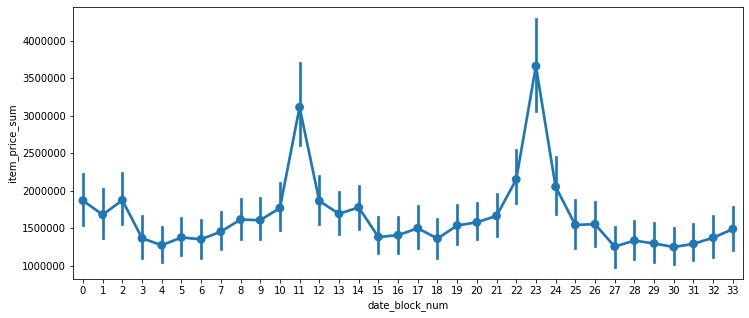

In [336]:
fig, axes  = plt.subplots(figsize = (12,5))
sns.pointplot(x = 'date_block_num', y = 'item_price_sum', data = montly_shops_revenue, ax = axes)

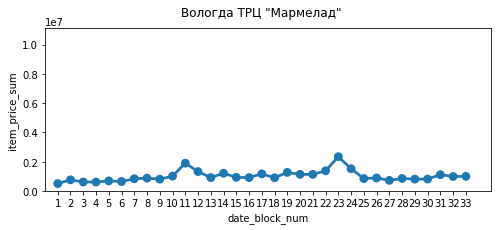

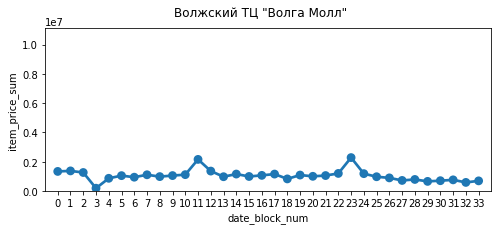

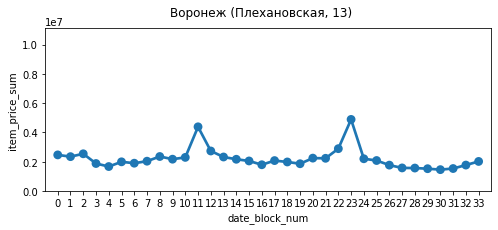

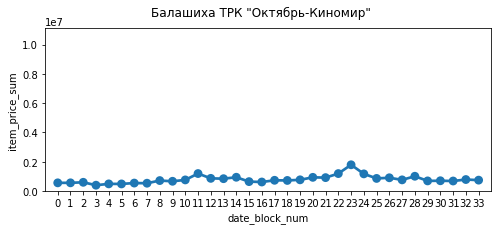

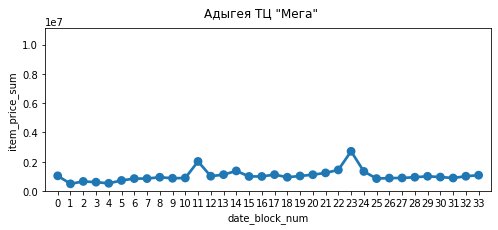

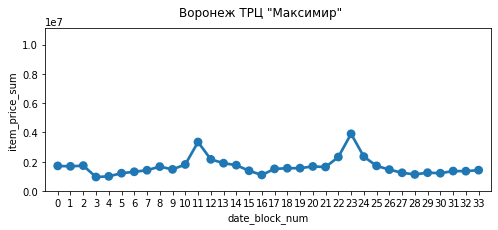

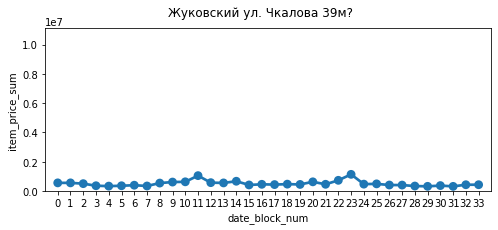

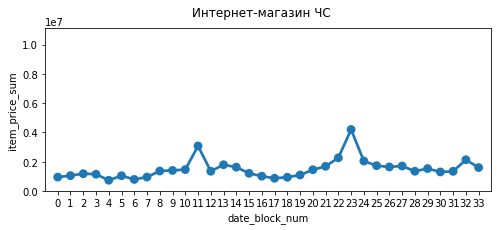

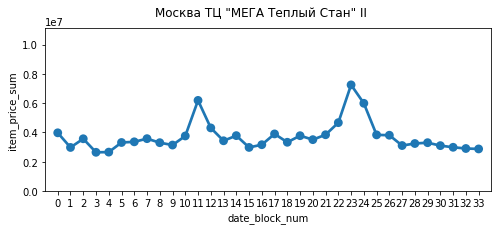

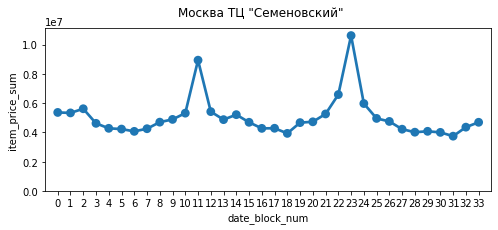

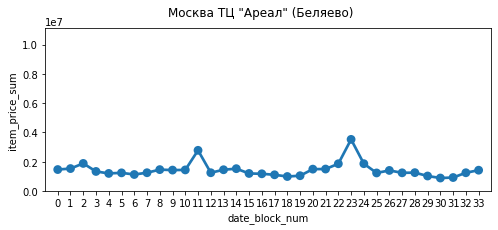

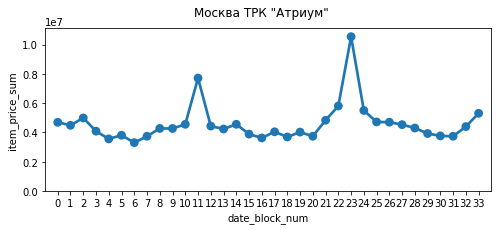

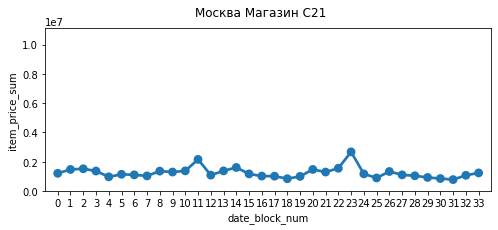

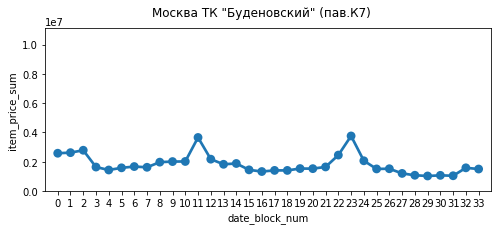

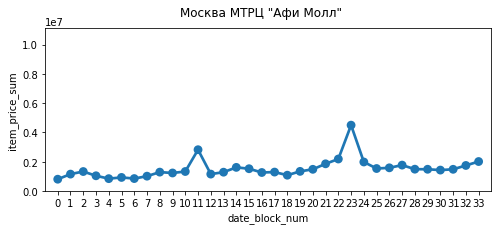

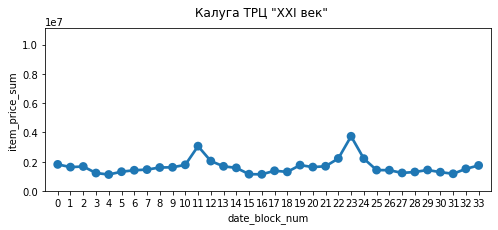

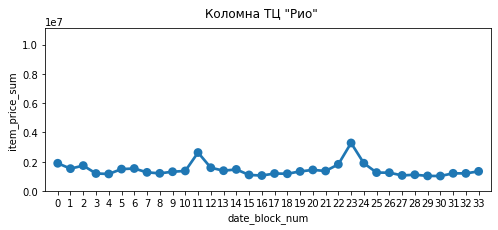

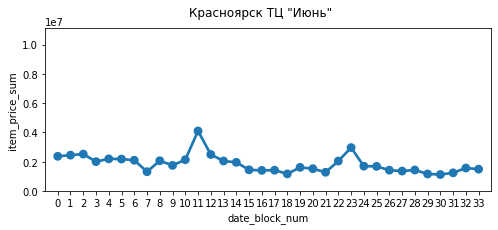

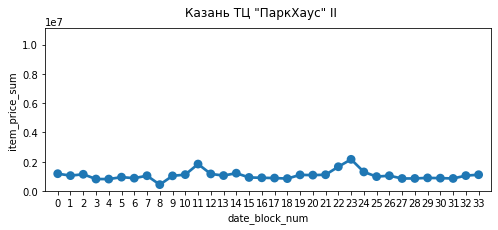

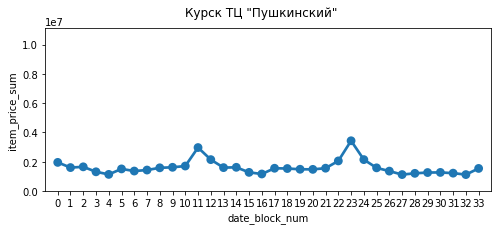

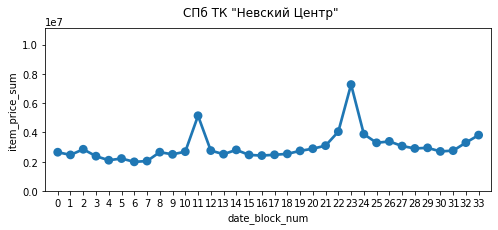

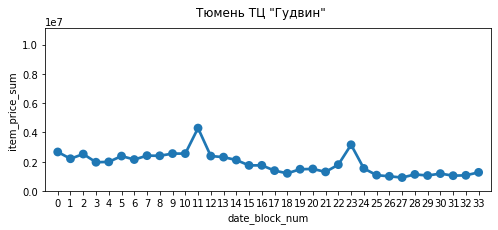

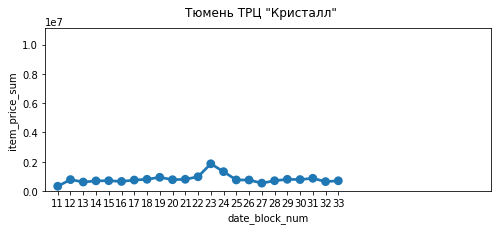

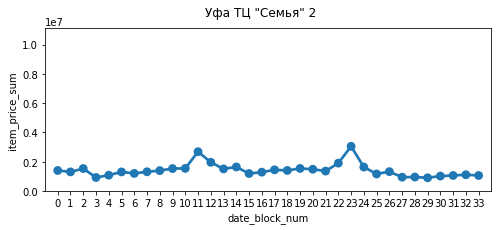

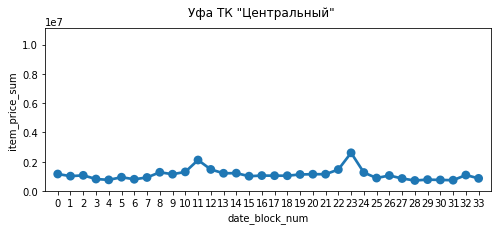

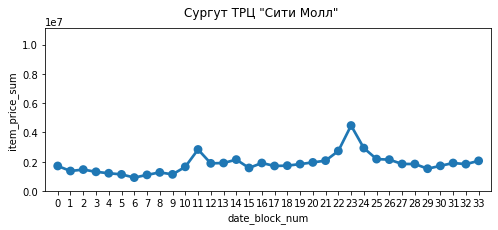

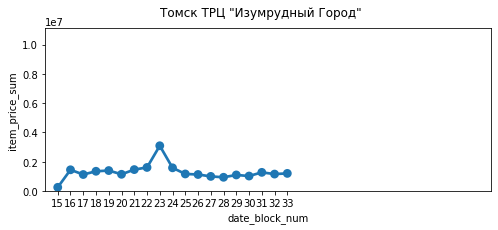

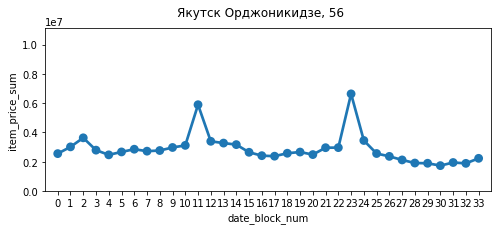

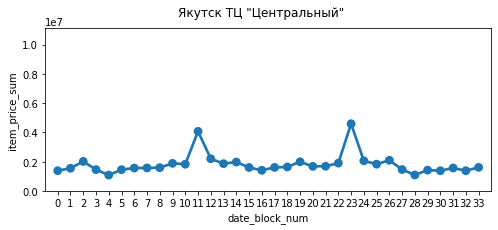

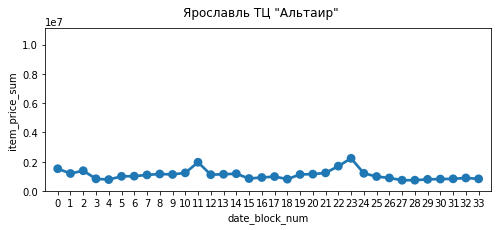

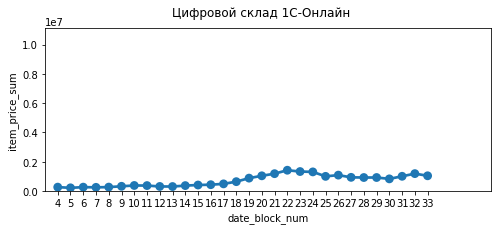

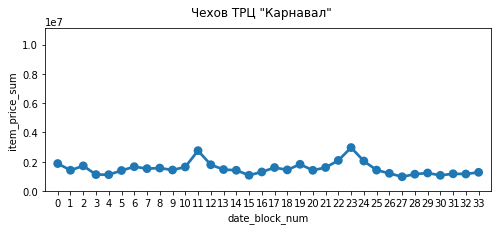

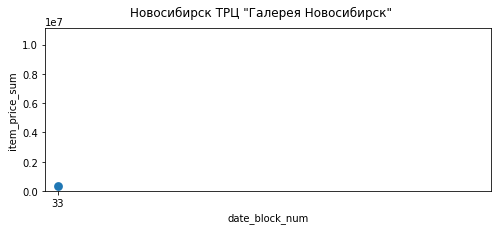

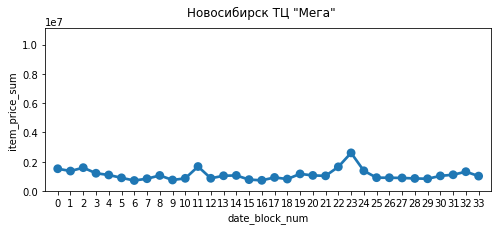

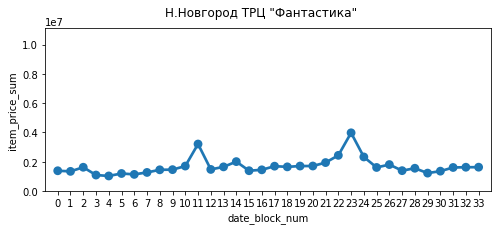

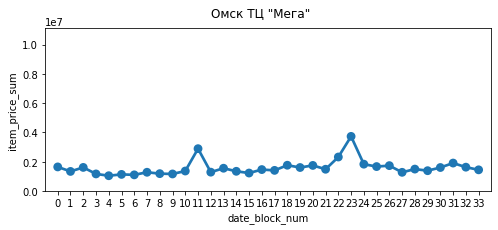

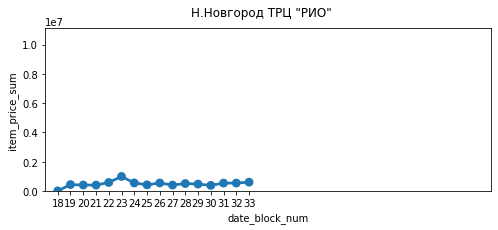

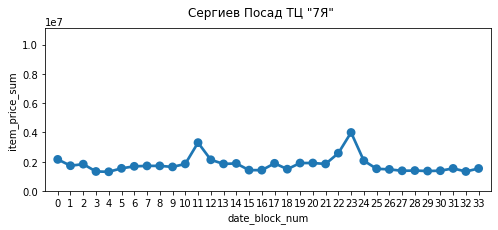

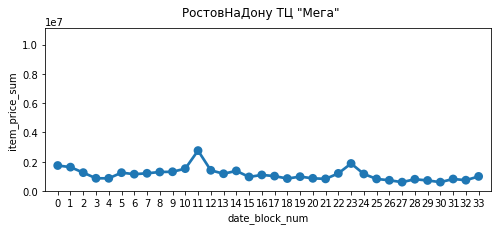

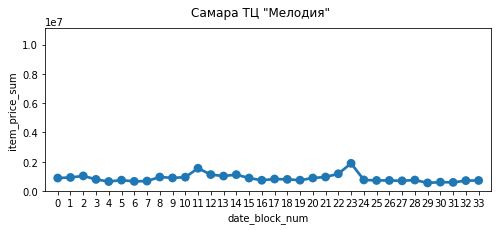

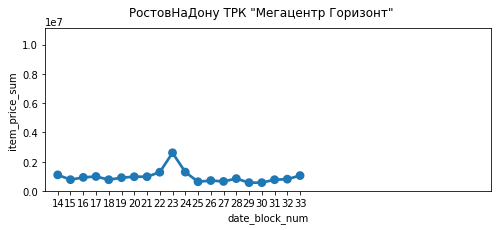

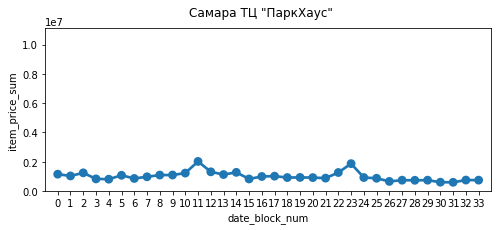

In [351]:
for shop_id in test_set_df['shop_id'].unique():
    fig, axes  = plt.subplots(figsize = (8,3))
    sns.pointplot(x = 'date_block_num', y = 'item_price_sum', 
                  data = montly_shops_revenue.loc[montly_shops_revenue['shop_id'] == shop_id], ax = axes)
    tit = shops_df.loc[shops_df['shop_id'] == shop_id,'shop_name'].values[0]
    axes.set_xlim(-1,34)
    axes.set_ylim(0, montly_shops_revenue['item_price_sum'].max()*1.05)
    fig.suptitle(tit)

- Validation data definately 10.2015 (33)
- What to do with 'Новосибирск ТРЦ "Галерея Новосибирск"'??
